# Air Quality Prediction Project


This notebook merges weather and air quality data, trains regression and classification models,
compares their performance, and deploys the best model using Gradio.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import joblib
import gradio as gr

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and merge datasets

In [2]:
# Load datasets
df_weather = pd.read_csv("weather_data_prepared.csv")
df_air = pd.read_csv("air_quality_prepared.csv")

# Convert datetime
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])
df_air["datetime"] = pd.to_datetime(df_air["datetime"])

# Merge on datetime
df_combined = pd.merge(df_air, df_weather, on="datetime", how="inner")

# Drop NA values
df_combined = df_combined.dropna(subset=["pm10", "temperature", "humidity", "wind_speed"])


## Feature Engineering

In [3]:
def categorize_pm10(value):
    if value < 20:
        return "Low"
    elif 20 <= value <= 40:
        return "Moderate"
    else:
        return "High"

df_combined["pm10_category"] = df_combined["pm10"].apply(categorize_pm10)
X = df_combined[["temperature", "humidity", "wind_speed"]]
y_reg = df_combined["pm10"]
y_clf = df_combined["pm10_category"]

## Regression Modeling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5  # same as np.sqrt
r2_rf = r2_score(y_test, y_pred_rf)

# Output
print(f"Linear Regression -> RMSE: {rmse_lr:.2f}, R^2: {r2_lr:.2f}")
print(f"Random Forest Regressor -> RMSE: {rmse_rf:.2f}, R^2: {r2_rf:.2f}")


Linear Regression -> RMSE: 8.42, R^2: 0.19
Random Forest Regressor -> RMSE: 8.67, R^2: 0.14


## Classification Modeling

In [5]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_c, y_train_c)
y_pred_log = log_clf.predict(X_test_c)
print("Logistic Regression Results:")
print(classification_report(y_test_c, y_pred_log))

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_c, y_train_c)
y_pred_rf_clf = rf_clf.predict(X_test_c)
print("Random Forest Classifier Results:")
print(classification_report(y_test_c, y_pred_rf_clf))

Logistic Regression Results:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       427
         Low       0.77      0.98      0.86     15662
    Moderate       0.56      0.12      0.20      4950

    accuracy                           0.76     21039
   macro avg       0.44      0.37      0.35     21039
weighted avg       0.70      0.76      0.69     21039



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Classifier Results:
              precision    recall  f1-score   support

        High       0.19      0.06      0.09       427
         Low       0.79      0.88      0.83     15662
    Moderate       0.43      0.29      0.35      4950

    accuracy                           0.73     21039
   macro avg       0.47      0.41      0.42     21039
weighted avg       0.69      0.73      0.70     21039



## Save Final Model

In [6]:
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X, y_reg)
joblib.dump(final_model, "final_rf_model.joblib")

['final_rf_model.joblib']

## Gradio App

In [7]:
model = joblib.load("final_rf_model.joblib")

def predict_pm10(temp, humidity, wind_speed):
    return float(model.predict([[temp, humidity, wind_speed]])[0])

demo = gr.Interface(
    fn=predict_pm10,
    inputs=[
        gr.Slider(-10, 40, value=20, label="Temperature (°C)"),
        gr.Slider(0, 100, value=50, label="Humidity (%)"),
        gr.Slider(0, 100, value=10, label="Wind Speed (km/h)")
    ],
    outputs=gr.Number(label="Predicted PM10 (µg/m³)"),
    title="PM10 Air Quality Predictor",
    description="Enter weather data to predict PM10 pollution level."
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Feature Importance Plot
This chart shows which features had the most impact on the predictions made by the Random Forest Regressor.

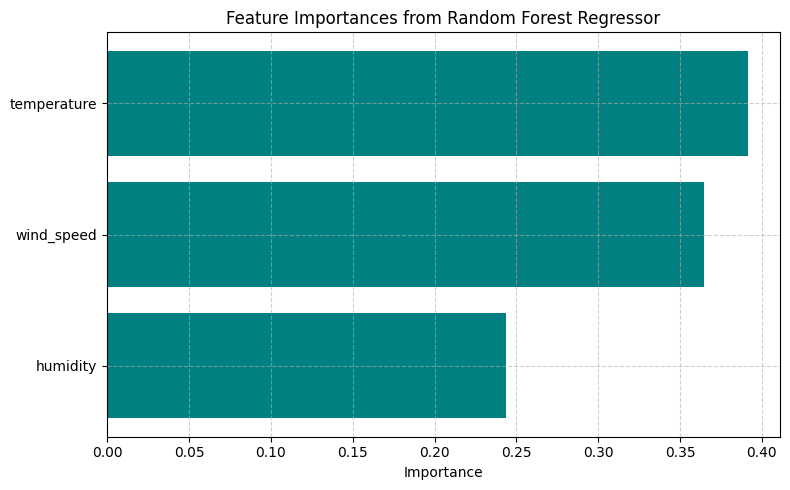

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor wa

In [8]:

import matplotlib.pyplot as plt
import pandas as pd

# Assuming the model and features are already defined
feature_names = ["temperature", "humidity", "wind_speed"]
importances = rf_model.feature_importances_
feature_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_df["Feature"], feature_df["Importance"], color="teal")
plt.xlabel("Importance")
plt.title("Feature Importances from Random Forest Regressor")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
